# <img src="./assets/anpl_solo_logo.png" style="height:50px;display:inline"> DDS 0970252 - Autonomous Planning Under Uncertainty
---

**Moshe Rafaeli** - [moshiktech@gmail.com](mailto:moshiktech@gmail.com) \
**Tamir Shazman** - [tmyr@campus.technion.ac.il](mailto:tmyr@campus.technion.ac.il)

Course website: https://anpl-technion.github.io/Teaching/#POMDP \
Course forum and announcements: https://piazza.com/technion.ac.il/fall2025/0970252


## <img width="48" height="48" src="https://img.icons8.com/external-flat-icons-inmotus-design/67/external-bacterium-illness-flat-icons-inmotus-design-2.png" alt="external-bacterium-illness-flat-icons-inmotus-design-2"/> Tutorial 2: Non-Parametric Inference

---

**Notebook kernel:** `Julia` (recommended version ≥ 1.11)

**Packages used (install if needed):**

In [1]:
using Pkg
Pkg.add(["Distributions", "Random", "Plots", "ParticleFilters"])

  Installing known registries into `~/.julia`
       Added `General` registry to ~/.julia/registries
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed libdecor_jll ───────────────── v0.2.2+0
   Installed x265_jll ───────────────────── v4.1.0+0
   Installed libfdk_aac_jll ─────────────── v2.0.4+0
   Installed JpegTurbo_jll ──────────────── v3.1.3+0
   Installed GR_jll ─────────────────────── v0.73.19+1
   Installed LERC_jll ───────────────────── v4.0.1+0
   Installed Libmount_jll ───────────────── v2.41.2+0
   Installed HypergeometricFunctions ────── v0.3.28
   Installed Opus_jll ───────────────────── v1.5.2+0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.7+0
   Installed StatsFuns ──────────────────── v1.5.2
   Installed LoggingExtras ──────────────── v1.2.0
   Installed Preferences ────────────────── v1.5.0
   Installed RelocatableFolders ─────────── v1.0.1
   Installed PDMats ─────────────────────── v0.11.36
   Installed Marc

In [2]:
using Distributions, Random, Plots, ParticleFilters

### Sampling - Motivation

---


We are focusing on the smoothing case.
Recall the Bayes Filter:
$$
b_{k+1}(x_{0:k+1}) = ψ (b_k(x_{0:k}), a_{k}, z_{k+1}) = η^{-1} ⋅ \mathbb{P} ( z_{k+1} ∣ x_{k+1} ) ⋅ \mathbb{P} ( x_{k+1} ∣ x_{k} , a_{k}) ⋅ b_{k}(x_{0:k})
$$
where
$$
η = \mathbb{P} ( z_{k+1} ∣ b_{k}(x_{0:k}), a_{k}) = ∫_{x_{k+1}} \mathbb{P} ( z_{k+1} ∣ x_{k+1}) ∫_{x_{0:k}} \mathbb{P} ( x_{k+1} ∣ x_{k}, a_{k}) ⋅ b_{k}(x_{0:k})~dx_{0:k}~dx_{k+1}
$$

**Problem:**

The Theoretical Bayes Filter becomes intractable in high-dimensional or continuous spaces, because it requires computing integrals over all possible states and maintaining probability distributions over infinite state spaces. \
Using parametric models (e.g. normal distributions with $(\mu, \Sigma)$) to represent the posterior beliefs can be inaccurate for general distributions, as they may result in distributions that cannot be properly captured by parametric forms.

We want a _tractable_ solution for belief representation and belief propagation, for _general_ distributions.

### Perfect Monte Carlo Sampling

---


If we could magically draw $N$ samples directly from the true posterior $\mathbb{P} (x_{0:k} | b_0, a_{0:k-1}, z_{1:k})$:
$$
\{ x_{0:k}^i \}^N_{i=1} ∼ \mathbb{P} (x_{0:k} | b_0, a_{0:k-1}, z_{1:k})
$$

- How would we represent the belief?
    $$
    \hat{b}_k(x_{0:k}) = \hat{\mathbb{P}}_N (x_{0:k} ∣ b_0, a_{0:k-1}, z_{1:k} ) = \frac{1}{N} ∑_{i=1}^N δ(x_{0:k} - x_{0:k}^i)
    $$

- How would we compute the mean state?
    $$
    \hat{x}_{0:k} = \hat{\mathbb{E}}_N [ x_{0:k} ] = \frac{1}{N} ∑_{i=1}^N x_{0:k}^i
    $$ 
    why?
    $$
    \mathbb{E}_{b_{k}} [ x_{0:k} ] = ∫_{x_{0:k}} x_{0:k} ⋅ b_k (x_{0:k}) ~dx_{0:k}
    \xrightarrow{\text{replace with } \hat{b}_k(x_{0:k})}
    \mathbb{E}_{\hat{b}_{k}} [ x_{0:k} ] = ∫_{x_{0:k}} x_{0:k} ⋅ \hat{b}_k (x_{0:k}) ~dx_{0:k}
    = ∫_{x_{0:k}} x_{0:k} ⋅ \frac{1}{N} ∑_{i=1}^N δ(x_{0:k} - x_{0:k}^i) ~dx_{0:k}
    = \frac{1}{N} ∑_{i=1}^N ∫_{x_{0:k}} x_{0:k} ⋅ δ(x_{0:k} - x_{0:k}^i) ~dx_{0:k}
    = \frac{1}{N} ∑_{i=1}^N x_{0:k}^i
    $$


#### <img width="48" height="48" src="https://img.icons8.com/bubbles/100/question-mark.png" alt="question-mark"/> Question

Assume you have a set of $N$ independent and identically distributed (i.i.d) samples $\{x_{0:k-1}^i\}_{i=1}^{N}$ of the belief $b_{k-1}(x_{0:k-1})$ at time $k-1$,
and you are given the transition model $\mathbb{P}(x' ∣ x, a)$.
Then you performed an action $a_{k-1}$.

How would you represents the belief $b_k^{-}(x_{0:k}) = \mathbb{P}(x_{0:k} ∣ b_{k-1}, a_{k-1})$ using these samples and the transition model?


#### <img width="48" height="48" src="https://img.icons8.com/bubbles/100/light-on.png" alt="light-on"/> Answer

Recall the prediction step (Chain Rule):
$$
b_k^{-}(x_{0:k}) = \mathbb{P}(x_{0:k} ∣ a_{0:k-1}, z_{1:k-1}) = \mathbb{P}(x_k ∣ x_{k-1}, a_{k-1}) ⋅ \mathbb{P}(x_{0:k-1} ∣ a_{0:k-2}, z_{1:k-1}) = \mathbb{P}(x_k ∣ x_{k-1}, a_{k-1}) ⋅ b_{k-1}(x_{0:k-1})
$$

Applying the sampled belief:
$$
\hat{b}_k^{-}(x_{0:k}) =
\mathbb{P} (x_k ∣ x_{k-1}, a_{k-1}) ⋅ \hat{b}_{k-1}(x_{0:k-1}) =
\frac{1}{N} \sum_{i=1}^{N} \mathbb{P} (x_k ∣ x_{k-1}, a_{k-1}) ⋅ δ (x_{0:k-1} - x_{0:k-1}^{i}) =
\frac{1}{N} \sum_{i=1}^{N} \mathbb{P} (x_k ∣ x_{k-1}^{i}, a_{k-1}) ⋅ δ (x_{0:k-1} - x_{0:k-1}^{i})
$$


For each sample $x_{0:k-1}^i$, we sample one new state  according to $x_k^i ∼ \mathbb{P} (x_k | x_{k-1}^i, a_{k-1})$. \
The new samples $\{x_{0:k}^i\}_{i=1}^{N}$ (with uniform weights $\frac{1}{N}$), where $x_{0:k}^i ≡ (x_{0:k-1}^i, x_{k}^i)$, are the representation of the predicted belief $b_k^{-}(x_k)$.
$$
\hat{b}_k^{-}(x_{0:k}) =
\frac{1}{N} \sum_{i=1}^{N} δ (x_{0:k} - x_{0:k}^{i})
$$

### Importance Sampling

---


**Problem:**

Sampling directly from the belief $b_k(x_{0:k})$ is usually impossible, because the posterior distribution can be of multi-modal or just of a general unstructured form.

**Solution:**

Sample from an _easier_ distribution (denoted as the _proposal distribution_) $q(x)$, then correct the weight of each sample (i.e., instead of uniform samples weights $\frac{1}{N}$, each sample has different weight).


##### <img width="48" height="48" src="https://img.icons8.com/bubbles/100/question-mark.png" alt="question-mark"/> Question

Assume you have a set of $N$ independent and identically distributed (i.i.d) samples $\{x_{k}^{i}\}_{i=1}^{N}$ of some distribution $q(x_{0:k} ∣ a_{0:k-1}, z_{1:k} )$, and you have access to the _values_ of the belief $b_{k}(x_{0:k})$ for different states $x_k$.

- How would you represent the belief $b_{k}(x_{0:k})$ using these samples?

- What is the expected state at time $k$ according to the represented belief $b_k(x_{0:k})$?


##### <img width="48" height="48" src="https://img.icons8.com/bubbles/100/light-on.png" alt="light-on"/> Answer

- The sampled proposal distribution:
    $$
    \hat{q}_N (x_{0:k}) = \frac{1}{N} ∑_{i=1}^N δ(x_{0:k} - x_{0:k}^i)
    $$
    For any $x_{0:k}$ where $q(x_{0:k})≠0$ (i.e., the support of $q$ includes the support of $b_k$):
    $$
    b_k(x_{0:k}) = \mathbb{P}(x_{0:k} ∣ a_{0:k-1}, z_{1:k} ) =
    q(x_{0:k} ∣ a_{0:k-1}, z_{1:k} ) ⋅ \underbrace{\frac{\mathbb{P}(x_{0:k} ∣ a_{0:k-1}, z_{1:k} )}{q(x_{0:k} ∣ a_{0:k-1}, z_{1:k} )}}_{\triangleq w(x_{0:k} ∣ a_{0:k-1}, z_{1:k})} = 
    q(x_{0:k} ∣ a_{0:k-1}, z_{1:k} ) ⋅ w(x_{0:k} ∣ a_{0:k-1}, z_{1:k})
    $$
    Introduce the sampled proposal distribution:
    $$
    \hat{b}_k(x_{0:k}) =
    \hat{q}_N(x_{0:k} ∣ a_{0:k-1}, z_{1:k} ) ⋅ w(x_{0:k} ∣ a_{0:k-1}, z_{1:k}) =
    \frac{1}{N} ∑_{i=1}^N w(x_{0:k} ∣ a_{0:k-1}, z_{1:k}) ⋅ δ(x_{0:k} - x_{0:k}^i) =
    \frac{1}{N} ∑_{i=1}^N \underbrace{w(x_{0:k}^i ∣ a_{0:k-1}, z_{1:k})}_{≜ w_k^i} ⋅ δ(x_{0:k} - x_{0:k}^i) =
    \frac{1}{N} ∑_{i=1}^N w_k^i ⋅ δ(x_{0:k} - x_{0:k}^i)
    $$


- Calculated the expectation of the state according to $\hat{b}_k(x_{0:k})$:
    $$
    \hat{x}_{0:k} = \hat{\mathbb{E}}_{N}^{IS} \left[ x_{0:k} \right] =
    ∫_{x_k} \hat{b}_k(x_{0:k}) ⋅ x_{0:k} ~dx_{0:k} =
    ∫_{x_k} \frac{1}{N} ∑_{i=1}^N w_k^i ⋅ δ(x_{0:k} - x_{0:k}^i) ⋅ x_k ~dx_{0:k} =
    \frac{1}{N} ∑_{i=1}^N w_k^i ⋅ x_{0:k}^i
    $$

    We correct the samples $\{ x_{0:k}^i \}_{i=1}^{N}$ taken from $q(x_{0:k})$ using corresponding weights $w_k^i$ calculated according to the ratio between the distributions.

### Self-Normalized Importance Sampling

---

**Problem:**

We assumed we have access to the _values_ of the belief $b_k(x_k)$ at the states $x_k$, but in practice they would be known only up to some constant, because:
$$
b_k(x_{0:k}) = \mathbb{P}(x_{0:k} ∣ a_{0:k-1}, z_{1:k}) = \eta^{-1} ⋅ \mathbb{P}(z_k ∣ x_k) ⋅ \mathbb{P}(x_k ∣ x_{k-1}, a_{k-1}) ⋅ b_{k-1}(x_{0:k-1})
$$
where $\eta$ is computationally expensive (or even impossible) to calculate.

**Solution:**

Ensure the calculated weights are normalized accordingly, by making sure the represented belief $\hat{b}_k(x_k)$ is a _valid probability distribution_.
$$
1 = ∫_{x_{0:k}} \hat{b}_k(x_{0:k}) ~dx_{0:k} =
∫_{x_{0:k}} \frac{1}{N} ∑_{i=1}^N w_k^i ⋅ δ(x_{0:k} - x_{0:k}^i) ~dx_{0:k} =
\frac{1}{N} ∑_{i=1}^N w_k^i ⋅ ∫_{x_k} δ(x_k - x_k^i) ~dx_k =
\frac{1}{N} ∑_{i=1}^N w_k^i
$$

Therefore, we can design normalized weights such that:
$$
\hat{b}_k(x_{0:k}) = \frac{1}{N} ∑_{i=1}^N w_k^i ⋅ δ(x_{0:k} - x_{0:k}^i) =
\frac{1}{N} ∑_{i=1}^N \frac{w_k^i}{1} ⋅ δ(x_{0:k} - x_{0:k}^i) =
\frac{1}{N} ∑_{i=1}^N \frac{w_k^i}{\frac{1}{N} \sum_{j=1}^N w_k^j} ⋅ δ(x_{0:k} - x_{0:k}^i) =
∑_{i=1}^N \underbrace{\frac{w_k^i}{\sum_{j=1}^N w_k^j}}_{≜ \tilde{w}_k^i} ⋅ δ(x_{0:k} - x_{0:k}^i) =
∑_{i=1}^N \tilde{w}_k^i ⋅ δ(x_{0:k} - x_{0:k}^i)
$$

### Sequential Importance Sampling

---

We know how to represent a belief $\hat{b}_k(x_{0:k})$ at each time step $k$.

**Problem:**

Generally, we would need to sample from a new proposal distribution $q(x_{0:k+1} ∣ ⋯ )$ and recalculate calculate the weights again.
This can easily become intractable as $k$ increases.

**Solution:**

What if our proposal distribution had a recursive structure?
$$
q(x_{0:k+1} ∣ a_{0:k}, z_{1:k+1}) = q(x_{k+1} ∣ x_{0:k}, a_{0:k}, z_{1:k+1}) ⋅ q(x_{0:k} ∣ a_{0:k-1}, z_{1:k}) = ⋯ = q(x_0) ∏_{t=1}^{k+1} q(x_{0:t} ∣ a_{0:t-1}, z_{1:t})
$$

The weights also become recursive:
$$
w_{k+1}^i = \frac{\mathbb{P}(x_{0:k+1}^i ∣ a_{0:k}, z_{1:k+1})}{q(x_{0:k+1}^i | a_{0:k}, z_{1:k+1})} =
\frac{\mathbb{P}(z_{k+1} ∣ x_{k+1}^i) ⋅ \mathbb{P}(x_{k+1}^i ∣ x_{k}^i, a_{k})}{q(x_{k+1}^i | x_{0:k}^i, a_{0:k}, z_{1:k+1})} ⋅ \frac{\mathbb{P}(x_{0:k}^i ∣ a_{0:k-1}, z_{1:k})}{q(x_{0:k}^i | a_{0:k-1}, z_{1:k})} =
\frac{\mathbb{P}(z_{k+1} ∣ x_{k+1}^i) ⋅ \mathbb{P}(x_{k+1}^i ∣ x_{k}^i, a_{k})}{q(x_{k+1}^i | x_{0:k}^i, a_{0:k}, z_{1:k+1})} ⋅ w_k^i
$$

We can sample $\{ x_{k+1}^i \} ∼ \mathbb{P}(x_{k+1}^i ∣ x_{k}^i, a_{k})$ (instead of the whole trajectory), construct the new sample $\{ x_{0:k+1}^i \} ≜ ( x_{0:k}^i, x_{k+1}^i )$, and update the weights of the new samples according to their previous weights, the models and the recursive proposal distribution.

### Bootstrap Particle Filter

---

Combining all together - specifically, define the proposal distribution as the prior and the transition model:
$$
q(x_0) ≔ \mathbb{P}(x_0)
$$
$$
q(x_k ∣ x_{0:k-1}, a_{0:k-1}, z_{1:k}) ≔ \mathbb{P} (x_k ∣ x_{k-1}, a_{k-1})
$$

Then the weights are recursively calculated as:
$$
w_k^i =
\frac{\mathbb{P}(z_{k} ∣ x_{k}^i) ⋅ \mathbb{P}(x_{k}^i ∣ x_{k-1}^i, a_{k-1})}{\mathbb{P} (x_k^i ∣ x_{k-1}^i, a_{k-1})} ⋅ w_{k-1}^i =
\mathbb{P}(z_{k} ∣ x_{k}^i) ⋅ w_{k-1}^i
$$

**Problem:**

The weights are continuously multiplied according to the observation models over the sampled states $\mathbb{P}(z ∣ x^i)$. \
This means that particles (samples) with lower likelihoods according to the observation model will diminish to zero, leading them to have negligible weights. \
This will lead to a poor representation of the posterior distributions.

**Solution: Resampling**

"Throw away" particles with low likelihoods (weights) and explore more the particles with high likelihoods.

For a given set of weighted samples $\{ x_{0:k}^i, w_k^i \}_{i=1}^N$, we _resample_ $N$ particles, with repetitions, from the weighted particle posterior distribution.
$$
\{ \bar{x}_{0:k}^j \}_{j=1}^N ∼ \hat{\mathbb{P}}_N( x_{0:k} ; \{x_{0:k}^i, w_k^i\}_{i=1}^N )
$$
Effectively, particles with high weights will be drawn many times, while particles with low weights will not be drawn. \
We sample _with repetitions_ to allow drawing particles with high weights multiple times, giving them more representation in the new particles set. \
Finally, we set the weights of the new $N$ particles to be uniform $1/N$.

**Note:** The new set is evenly weighted, but remember that a sample with high-likelihood can appear multiple times in the new samples set.
This representation allows us to explore this sample multiple times in the next prediction step, correspondingly to it's weight before the resampling.

<img src="./assets/BootstrapFilter2.png" alt="Bootstrap Filter" width="50%"/>


#### When to Resample?

Logically, we want to resample when we have many particles (samples) with negligible weights which do not contribute to the estimation.
i.e. we want to measure how spread out or narrow are the samples. \
If the weights are narrow, we should resample. Otherwise, no need to resample (or we might lose a sample with high weight).

The **Effective Sample Size (ESS)** represents the number of particles that _effectively_ contribute to the approximation of the posterior distribution. 

When weights become very uneven, many particles have negligible weights and don't contribute meaningfully to the estimation, reducing the ESS. \
A low ESS indicates particle degeneracy, where only a few particles carry most of the probability mass.

Mathematically, ESS is computed as:
$$
ESS = \frac{1}{\sum_{i=1}^N {w_k^i}^2}
$$
- If the weights are evenly spread out, $∀ i: w_k^i ≈ 1/N$, then:
    $$ ESS = \left( \sum_{i=1}^N {w_k^i}^{2} \right)^{-1} ≈ \left( N ⋅ \frac{1}{N^2}\right)^{-1} = N ,$$
    meaning all $N$ particles contribute to the estimation.
- If only 1 weight is non-zero, $∃ i: w_k^i ≈ 1, ∀j≠i: w_k^{j} ≈ 0$, then:
    $$ ESS = \left( \sum_{i=1}^N {w_k^i}^{2} \right)^{-1} ≈ \left( (N-1) ⋅ 0^2 + 1^2 \right)^{-1} = 1 ,$$
    meaning only $1$ particle contributes to the estimation.

In practice, we set a reasonable threshold of $\frac{N}{2}$, so when $ESS < \frac{N}{2}$ we trigger resampling to redistribute particles and maintain a diverse set of hypotheses about the true state. \
This threshold balances between:
- Resampling too frequently (losing particle diversity)
- Resampling too rarely (suffering from particle degeneracy)


In [11]:
# Parameters - you can change these and see how they affect the estimation
n_particles = 100
n_steps = 50
σ_t = 0.1  # transition noise std
σ_o = 0.2  # observation noise std
actions = [0.1, -0.1]
ess_threshold = 0.5 # normalized ess
;

rmses[end] = 0.11146007777864954


┌ Info: Saved animation to /Users/jonathansomer/repos/apuu-hw2/tutorials/tutorial2/assets/particle_filter_example.gif
└ @ Plots /Users/jonathansomer/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Plots.AnimatedGif("/Users/jonathansomer/repos/apuu-hw2/tutorials/tutorial2/assets/particle_filter_example.gif")
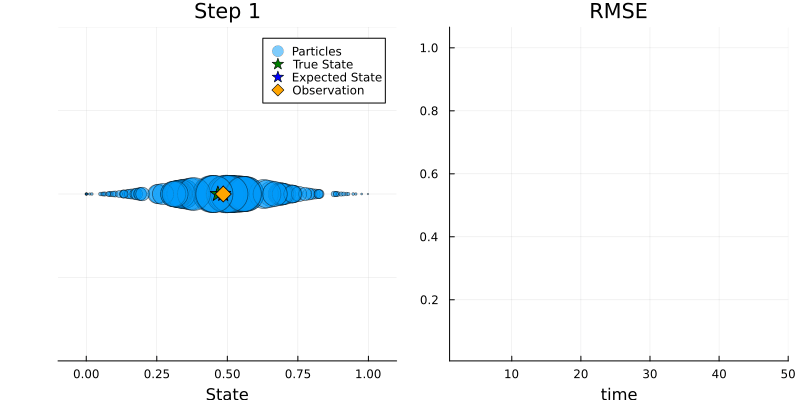

In [12]:
rng = MersenneTwister(0970252)

transition_model(state, action, rng) = clamp(rand(rng, Normal(state .+ action, σ_t)), 0, 1)
observation_model(previous_state, action, state, rng) = rand(rng, Normal(state, σ_o))
observation_likelihood(previous_state, action, state, observation) = pdf(Normal(state, σ_o), observation)

pf = BootstrapFilter(transition_model, observation_likelihood, n_particles; resample_threshold=ess_threshold, rng=rng) # Particle Filter updater
belief = ParticleCollection(rand(rng, n_particles)) # Prior Particle Belief - unweighted and uniformly sampled from [0,1].

true_state = 0.5 # True state starts at 0.5
states = [true_state]
est_states = [mean(belief)]
observations = Float64[]
rmses = Float64[]

anim = @animate for t in 1:n_steps
    # Select random action
    action = rand(rng, actions)

    # Update true state
    previous_state = true_state
    global true_state = clamp(transition_model(previous_state, action, rng), 0, 1) # make sure the state does not exceed the bounds of [0,1]
    push!(states, true_state)

    # Generate observation
    observation = observation_model(previous_state, action, true_state, rng)
    push!(observations, observation)

    # Update the particle belief
    global belief = update(pf, belief, action, observation)
    est_state = mean(belief)
    push!(est_states, est_state)

    # Plotting
    p1 = scatter(collect(particles(belief)), zeros(n_particles),
                label="Particles", markersize=collect(weights(belief) ./ weight_sum(belief)) * n_particles * 10, alpha=0.5,
                xlabel="State", yaxis=false, title="Step $t", xlims=[-0.1,1.1], ylims=[-0.5,0.5])
    scatter!(p1, [true_state], [0.0], label="True State",
                markersize=8, markershape=:star, color=:green)
    scatter!(p1, [est_state], [0.0], label="Expected State",
                markersize=8, markershape=:star, color=:blue)
    scatter!(p1, [observation], [0.0], label="Observation",
                markersize=8, markershape=:diamond, color=:orange)

    rmse = sqrt(mean((states .- est_states).^2))
    push!(rmses, rmse)

    p2 = plot(1:t, rmses, xlims=[1,n_steps],
                title="RMSE", xlabel="time", legend=false)
    plot(p1, p2, layout=(1,2), size=(800,400))
end

@show rmses[end]
gif(anim, "./assets/particle_filter_example.gif", fps=2)

### <img width="48" height="48" src="https://img.icons8.com/external-bearicons-outline-color-bearicons/64/external-copyright-graphic-design-bearicons-outline-color-bearicons.png" alt="external-copyright-graphic-design-bearicons-outline-color-bearicons"/> Credits

---

- Icons from [Icons8](https://icons8.com/)
- Bootstrap Filter Algorithm image from [Doucet et al. (2001)]()
    - _"Sequential Monte Carlo methods in practice, volume 1."_ by Doucet, A., De Freitas, N., Gordon, N. J., et al. (2001). Springer.